# ONS Census 2021 - PII Risk

In [1]:
import os, pathlib, math, warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import combinations

In [2]:
root = pathlib.Path("data")
area_size = "msoa"
target_codes = ["TS001", "TS004", "TS007A", "TS030", "TS058", "TS059", "TS050", "TS067", "TS037"]

Constants for the program. Target codes are the data sources we are interested in.

In [3]:
region_sizes = {"Country" : "ctry",
                "Region" : "rgn",
                "Upper-Tier Local Authority" : "utla",      #153 in England
                "Lower-Tier Local Authority" : "ltla",      #296 in England
                "Middle-Layer Super Output Area" : "msoa",  #2000-6000 households; 5000-15000 persons
                "Lower-Layer Super Output Area" : "lsoa",   #400-1200 households; 1000-3000 persons
                "Output Area" : "oa"}                       #40-250 households; 100-625 persons

region_indices = {3 : "ctry", #how many are per country
                  10 : "rgn",
                  174 : "utla",
                  331 : "ltla",
                  7264 : "msoa",
                  35672 : "lsoa",
                  188800 : "oa"}

regions = list(region_sizes.values())

Information about geographical levels for use in code and for deciding which to use.

### Importing/Cleaning Data

In [4]:
def check_region(region : str) -> str:
    """Checks the given region string.

    Args:
        region (str): Region string to be checked.

    Raises:
        ValueError: Region code not valid.

    Returns:
        str: Casted and verified version of region string.
    """
    region = str(region)
    if region not in regions:
        regions_error = '\n'.join(f"{key}  :  {val}" for key, val in region_sizes.items()) #formulate error string to show valid region strings
        raise ValueError(f"Region code must be one of the following: \nRegion  :  Region Code\n{regions_error}")
    return region

In [5]:
def get_codes_df() -> pd.DataFrame:
    """Gets a pd.DataFrame of all census codes and files, from https://www.nomisweb.co.uk/census/2021/bulk

    Returns:
        pd.DataFrame: Dataframe of all census codes, filenames and descriptions
    """
    codes = pd.read_csv(root / "census_codes.csv")
    #removes the .zip extension, as we are using the root to formulate the folder and csv path names
    codes["Filename"] = (
    codes["Filename"].str.split(".")
    .apply(lambda x: x[0]) 
    )
    return codes

In [6]:
def import_data(region : str, target_codes: list[str] = None, all : bool = False) -> dict[str, pd.DataFrame]: 
    """Imports csv data from given codes.

    Args:
        region (str): Region string.
        target_codes (list[str], optional): List of census characteristic codes as found on https://www.nomisweb.co.uk/census/2021/bulk. Defaults to None.
        all (bool, optional): Whether to import all available census data. Defaults to False.

    Raises:
        ValueError: All the given codes are wrong or not as found on https://www.nomisweb.co.uk/census/2021/bulk.

    Returns:
        dict[str, pd.DataFrame]: Dictionary of census characteristic codes and its associated pd.DataFrame.
    """
    region = check_region(region) #verify region
    
    codes = get_codes_df()
    
    if all:
        valid_target_codes = codes["Code"].values #gets all codes if user wants to import all data
    else:
        valid_target_codes = [code for code in target_codes if code in codes["Code"].values] #checks if each code is in the codes dataframe
        if len(valid_target_codes) == 0: #raises fatal error if there are no valid codes, hence nothing to import
            raise ValueError("Inputs not found in code database, ensure codes are in the form 'TSXXX' where X's are digits, as found on https://www.nomisweb.co.uk/census/2021/bulk")
        erroneous_codes = [code for code in target_codes if code not in valid_target_codes]
        output_erroneous_codes = '\n'.join(erroneous_codes) #formulate error string
        if len(erroneous_codes) > 0: #non-fatal warning if some codes were valid and imported
            warnings.warn(f"The following codes were not imported as they are invalid: {output_erroneous_codes}\nEnsure codes are in the form 'TSXXX' where X's are digits, as found on https://www.nomisweb.co.uk/census/2021/bulk")
        
    data = {} #initialise dictionary
    for code in valid_target_codes:
        folder = codes.loc[codes["Code"] == code, "Filename"].item() #locates the .zip file name (codes dataframe ripped from https://www.nomisweb.co.uk/census/2021/bulk)
        try: 
            data.update({code : pd.read_csv(root / folder / f"{folder}-{region}.csv").drop(columns="date")}) #automatically removes date column, as it is unnecesary for our use
        except FileNotFoundError: #non-fatal warning if unable to find file
            warnings.warn(f"File {folder}-{region}.csv not found in data/{folder}")
    
    return data

In [7]:
def cleanup_all(data : dict[str, pd.DataFrame], remove_geography : bool = True, remove_geography_code : bool = True) -> dict[str, pd.DataFrame]:
    """Removes data column, plus optional geography columns, from all pd.DataFrame in dictionary.

    Args:
        data (dict[str, pd.DataFrame]): Dictionary of codes and pd.DataFrame, where dataframes are to have columns removed.
        remove_geography (bool, optional): Whether to remove the 'goegraphy' column. Defaults to True.
        remove_geography_code (bool, optional): Whether to remove the 'geography code' column. Defaults to True.

    Returns:
        dict[str, pd.DataFrame]: Dictionary of codes and pd.Dataframe, where dataframes have had columns removed.
    """
    for key in data.keys():
        dataframe = data[key]
        try:
            if remove_geography:
                dataframe = dataframe.drop(columns="geography")
        except KeyError: #in case these columns have already been removed
            pass
        try:
            if remove_geography_code:
                dataframe = dataframe.drop(columns="geography code")
        except KeyError:
            pass
        data[key] = dataframe #saving changes to data
    return data

In [8]:
def cleanup(dataframe : pd.DataFrame, columns : list[str]) -> pd.DataFrame:
    """Removes given column names from pd.DataFrame.

    Args:
        dataframe (pd.DataFrame): pd.DataFrame to be cleaned.
        columns (list[str]): List of column names to be removed from pd.DataFrame.

    Returns:
        pd.DataFrame: pd.Dataframe with the given columns removed.
    """
    if type(columns) is not list:
        raise ValueError("Parameter 'columns' must be a list")
    elif len([column for column in columns if type(column) is str]) == 0:
        raise ValueError("Parameter 'columns' must be a list of strings")  
    for column in columns: #iteratively tries to do df.drop for each column given
        try:
            dataframe = dataframe.drop(columns=column)
        except KeyError:
            warnings.warn(f"Column {column} does not exist ") #no fatal error, warning instead
    return dataframe


In [9]:
def factor_in_age(df : pd.DataFrame, name : str = "Not accounted for") -> pd.DataFrame:
    """Adds a column to given dataframe to account for people not included in data.

    Args:
        df (pd.DataFrame): Dataframe to be modified
        name (str, optional): Name of column which contains unaccounted people. Defaults to "Not accounted for".

    Returns:
        pd.DataFrame: Modified dataframe
    """
    df_age = import_data(region_indices[len(df.index)], target_codes=["TS004"])["TS004"] #uses TS004 country of birth to find total numbers
    df_age_totals_column = [column for column in list(df_age.columns) if "Total" in column][0] #gets total numbers of people from reference and 
    df_totals_column = [column for column in list(df.columns) if "Total" in column][0] #given dataframes
    name = str(name)
    df[name] = df_age[df_age_totals_column] - df[df_totals_column] #calculates value of new column to account for those not used in data
    df[df_totals_column] = df_age[df_age_totals_column]
    df.rename(columns={df_totals_column:"Total"}, inplace=True) #modifies the total column to reflect all people
    return df

### Probability Function

Function to calculate probailities as a percent of the total in each region.

Data must be input in the form

<table style="border-collapse:collapse;border-spacing:0" class="tg"><thead><tr><th style="border-color:inherit;border-style:solid;border-width:1px;font-family:Arial, sans-serif;font-size:14px;font-weight:normal;overflow:hidden;padding:10px 5px;text-align:left;vertical-align:top;word-break:normal">Region<br></th><th style="border-color:inherit;border-style:solid;border-width:1px;font-family:Arial, sans-serif;font-size:14px;font-weight:normal;overflow:hidden;padding:10px 5px;text-align:left;vertical-align:top;word-break:normal">Population</th><th style="border-color:inherit;border-style:solid;border-width:1px;font-family:Arial, sans-serif;font-size:14px;font-weight:normal;overflow:hidden;padding:10px 5px;text-align:left;vertical-align:top;word-break:normal">Variable</th><th style="border-color:inherit;border-style:solid;border-width:1px;font-family:Arial, sans-serif;font-size:14px;font-weight:normal;overflow:hidden;padding:10px 5px;text-align:left;vertical-align:top;word-break:normal">...</th></tr></thead><tbody><tr><td style="border-color:inherit;border-style:solid;border-width:1px;font-family:Arial, sans-serif;font-size:14px;overflow:hidden;padding:10px 5px;text-align:left;vertical-align:top;word-break:normal">North East</td><td style="border-color:inherit;border-style:solid;border-width:1px;font-family:Arial, sans-serif;font-size:14px;overflow:hidden;padding:10px 5px;text-align:left;vertical-align:top;word-break:normal">2647013</td><td style="border-color:inherit;border-style:solid;border-width:1px;font-family:Arial, sans-serif;font-size:14px;overflow:hidden;padding:10px 5px;text-align:right;vertical-align:top;word-break:normal">2536430</td><td style="border-color:inherit;border-style:solid;border-width:1px;font-family:Arial, sans-serif;font-size:14px;overflow:hidden;padding:10px 5px;text-align:left;vertical-align:top;word-break:normal">...</td></tr><tr><td style="border-color:inherit;border-style:solid;border-width:1px;font-family:Arial, sans-serif;font-size:14px;overflow:hidden;padding:10px 5px;text-align:left;vertical-align:top;word-break:normal">North West</td><td style="border-color:inherit;border-style:solid;border-width:1px;font-family:Arial, sans-serif;font-size:14px;overflow:hidden;padding:10px 5px;text-align:left;vertical-align:top;word-break:normal">7417399</td><td style="border-color:inherit;border-style:solid;border-width:1px;font-family:Arial, sans-serif;font-size:14px;overflow:hidden;padding:10px 5px;text-align:left;vertical-align:top;word-break:normal">6885187</td><td style="border-color:inherit;border-style:solid;border-width:1px;font-family:Arial, sans-serif;font-size:14px;overflow:hidden;padding:10px 5px;text-align:left;vertical-align:top;word-break:normal">...</td></tr></tbody></table>

and will be output in the form

<table style="border-collapse:collapse;border-spacing:0" class="tg"><thead><tr><th style="border-color:inherit;border-style:solid;border-width:1px;font-family:Arial, sans-serif;font-size:14px;font-weight:normal;overflow:hidden;padding:10px 5px;text-align:left;vertical-align:top;word-break:normal">Region<br></th><th style="border-color:inherit;border-style:solid;border-width:1px;font-family:Arial, sans-serif;font-size:14px;font-weight:normal;overflow:hidden;padding:10px 5px;text-align:left;vertical-align:top;word-break:normal">Population</th><th style="border-color:inherit;border-style:solid;border-width:1px;font-family:Arial, sans-serif;font-size:14px;font-weight:normal;overflow:hidden;padding:10px 5px;text-align:left;vertical-align:top;word-break:normal">Probability</th><th style="border-color:inherit;border-style:solid;border-width:1px;font-family:Arial, sans-serif;font-size:14px;font-weight:normal;overflow:hidden;padding:10px 5px;text-align:left;vertical-align:top;word-break:normal">...</th></tr></thead><tbody><tr><td style="border-color:inherit;border-style:solid;border-width:1px;font-family:Arial, sans-serif;font-size:14px;overflow:hidden;padding:10px 5px;text-align:left;vertical-align:top;word-break:normal">North East</td><td style="border-color:inherit;border-style:solid;border-width:1px;font-family:Arial, sans-serif;font-size:14px;overflow:hidden;padding:10px 5px;text-align:left;vertical-align:top;word-break:normal">2647013</td><td style="border-color:inherit;border-style:solid;border-width:1px;font-family:Arial, sans-serif;font-size:14px;overflow:hidden;padding:10px 5px;text-align:right;vertical-align:top;word-break:normal">0.958233</td><td style="border-color:inherit;border-style:solid;border-width:1px;font-family:Arial, sans-serif;font-size:14px;overflow:hidden;padding:10px 5px;text-align:left;vertical-align:top;word-break:normal">...</td></tr><tr><td style="border-color:inherit;border-style:solid;border-width:1px;font-family:Arial, sans-serif;font-size:14px;overflow:hidden;padding:10px 5px;text-align:left;vertical-align:top;word-break:normal">North West</td><td style="border-color:inherit;border-style:solid;border-width:1px;font-family:Arial, sans-serif;font-size:14px;overflow:hidden;padding:10px 5px;text-align:left;vertical-align:top;word-break:normal">7417399</td><td style="border-color:inherit;border-style:solid;border-width:1px;font-family:Arial, sans-serif;font-size:14px;overflow:hidden;padding:10px 5px;text-align:left;vertical-align:top;word-break:normal">0.928248</td><td style="border-color:inherit;border-style:solid;border-width:1px;font-family:Arial, sans-serif;font-size:14px;overflow:hidden;padding:10px 5px;text-align:left;vertical-align:top;word-break:normal">...</td></tr></tbody></table>

In [10]:
def prob_calc(df):
    """
    Function that converts the population into a probability.
    
    Args:
        df (Pandas Dataframe): The dataframe to be converted.

    Returns:
        df (Pandas Dataframe): The converted dataframe.
    """
    for i in range(2,len(df.columns)):
        df[df.columns[i]] = df[df.columns[i]]/df[df.columns[1]]
    return df

### Correlation Calculations

In [11]:
def calculate_coefficient_distribution(df : pd.DataFrame = pd.DataFrame(), input_path : str = root/"coefficients.csv",
                                       output_to_file : bool = False, output_path : str = root/"most_correlated.csv",
                                       verbose : bool = True, visualise : bool = True) -> None:
    """Calculates the distribution of coefficients of correlation.
    
    Calculates the distribution of coefficients of correlation and selects the strongest correlated (both positive and negative)

    Args:
        df (pd.DataFrame, optional): pd.DataFrame of coefficients, with a column named 'coefficient'. Defaults to empty pd.DataFrame().
        input_path (str, optional): Input path of csv file containing a pd.DataFrame. Defaults to root/"coefficients.csv".
        output_to_file (bool, optional): Whether to output the most correlated to a csv file. Defaults to False.
        output_path (str, optional): Path to write csv file of output to. Defaults to root/"most_correlated.csv".
        verbose (bool, optional): Whether to print key distribution metrics. Defaults to True.
        visualise (bool, optional): Whether to visualise the distribution with Seaborn. Defaults to True.
        
    Returns:
        None
    """
    if df.empty:
        df = pd.read_csv(input_path)
    mean = df["coefficient"].mean() #calculates mean and standard deviation
    std = df["coefficient"].std()
    if visualise:
        fig, ax = plt.subplots(figsize=(10, 10)) #draws histogram of distribution
        sns.histplot(data=df, x='coefficient', ax=ax, bins=50, stat='density', kde=True)
    
    number_of_sd = 2.5 #found this to be the sweet spot
    upper_threshold = mean + number_of_sd*std
    lower_threshold = mean - number_of_sd*std

    above = df[df["coefficient"] > upper_threshold].sort_values("coefficient", ascending=False) #selecting those above and below thresholds
    below = df[df["coefficient"] < lower_threshold].sort_values("coefficient", ascending=True) #and sorting by strongest correlation
    
    if verbose:
        print(f"Mean:{mean}\nStandard Deviation:{std}")
        print(f"Upper threshold:{upper_threshold}\nLower threshold:{lower_threshold}")
        print(f"Number of significantly correlated pairs of characteristics: {len(above)+len(below)}")
        
    above = above.head(50) #selecting only top 50 from both to reduce number of strongly correlated data to be saved
    below = below.head(50)
    all = pd.concat([above, below])
    if output_to_file:
        all.to_csv(output_path)

In [12]:
def merge_normalise(dataframes : list[pd.DataFrame], columns : list[list[str]]) -> pd.DataFrame:
    """Merges and normalises a list of dataframes.
    
    Combines the two dataframes and divides each row by the total number of people

    Args:
        dataframes (list[pd.DataFrame]): List of pd.DataFrame
        columns (list[list[str]]): Nested list of column names, where columns[0] contains the column names of DataFrame dataframes[0]

    Returns:
        pd.Dataframe: Normalised and merged DataFrame
    """
    df_merged = dataframes[0].merge(dataframes[1], on="geography code") #merges on geography code
    df_normalised = df_merged.copy() 
    for column_set, total in zip(columns, [[column for column in df.columns if "Total" in column][0] for df in dataframes]):
            df_normalised[column_set] = df_normalised[column_set].divide(df_normalised[total], axis=0) #divides the relevant columns by the totals to normalise
    return df_normalised

In [13]:
def get_all_correlations(target_codes : list[str],
                         output_to_file : bool = False, 
                         output_path : str = root/"coefficients.csv") -> pd.DataFrame:
    """Creates file coefficients.csv.
    
    Calculates the Pearson's coefficient of correlation for all combinations of columns from the specified census data codes.
    Optionally writes a file to /data/coefficients.csv
    
    Args:
        target_codes (list[str]): A list of wanted census codes as given in https://www.nomisweb.co.uk/census/2021/bulk, in the form 'TSxxx' where x are digits
        visualise (bool): Whether to output a histogram of distribution of correlations, default = False
        verbose (bool): Whether to print out metrics such as standard deviation, default = False
    
    Returns:
        pd.DataFrame: DataFrame containing all coefficients, the columns used, and codes of datasets used.
    """
    #import and clean relevant data
    df_dict = cleanup_all(
                        import_data(
                                        area_size, 
                                        target_codes=target_codes
                                    ),
                        remove_geography_code=False)
    
    uid = 0 #sets uid to create a unique index
    keys = list(df_dict.keys())
    coefficients_list = [] #blank list to turn to dataframe at the end of the loop: for efficiency reasons
    for k1, k2 in combinations(keys, 2):
        if "TS007A" in [k1, k2] and "TS004" in [k1, k2]: #Country of birth and age by year together make the correlations data bad
            continue
        dataframes = [df_dict[k1], df_dict[k2]] #turned into list to iteratively address the dataframes
        #selecting relevant columns, excluding geography code, totals and "Country of birth: Europe; measures: Value" as that repeated data and did not bright any insight
        columns = [[column for column in df.columns if column != "geography code" and "Total" not in column and column != "Country of birth: Europe; measures: Value"] for df in dataframes] 
        
        df_normalised = merge_normalise(dataframes, columns) #normalise to compare accurately
        
        #calculates the pearsons coefficient of correlation for each combination of columns from each of the two dataframes
        data = [(
                np.corrcoef(
                    np.array(df_normalised[column1]), 
                    np.array(df_normalised[column2])
                )[0][1],
                column1,
                column2) 
                for column2 in columns[1]
                for column1 in columns[0]]
        
        #adds data row by row to list
        for p, c1, c2, in data:
            coefficients_list.append([uid, c1, c2, p, k1, k2]) #uid (as index); characteristic 1; characteristic 2; pearsons coefficient; key 1; key 2
            uid += 1
    
    #conversion to dataframe
    coefficients = pd.DataFrame(coefficients_list, columns=['uid', 'variable1', 'variable2', 'coefficient', "k1", "k2"])

    if output_to_file:
        coefficients.to_csv(output_path)
    
    return coefficients


Mean:-0.002478471466191243
Standard Deviation:0.2758666492936517
Upper threshold:0.6871881517679379
Lower threshold:-0.6921450947003205
Number of significantly correlated pairs of characteristics: 22


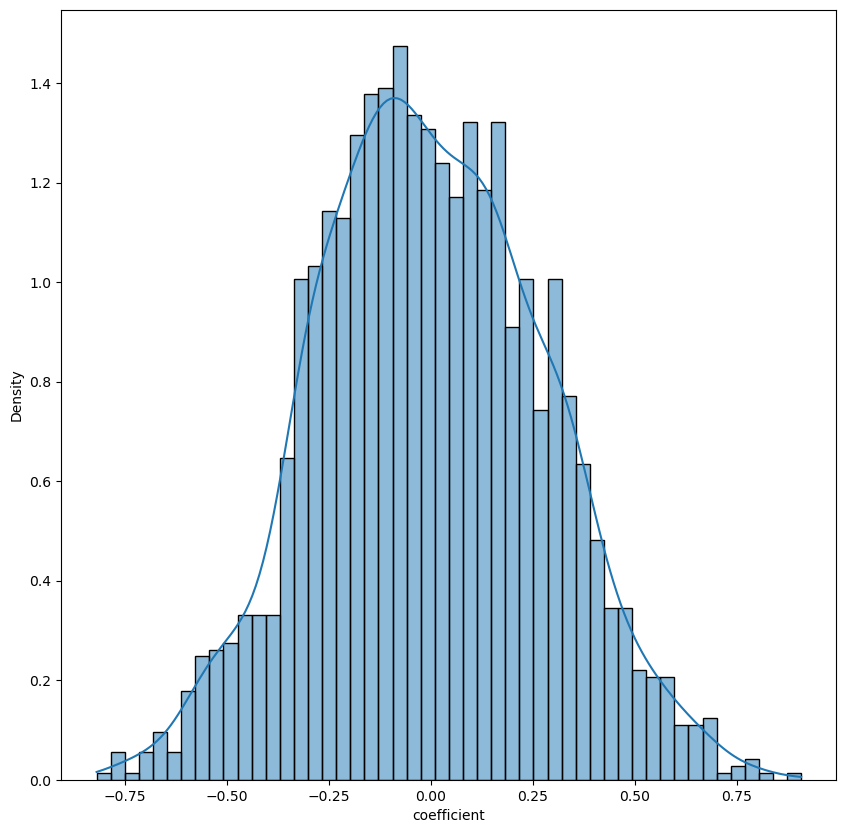

In [14]:
coefficients =  get_all_correlations(target_codes=target_codes)

calculate_coefficient_distribution(coefficients)

### Combining Variables

This function takes an input of 2 data frames of population values. The 2 data frames get passed through the prob_calc function, and then iterated through and combined. The output is a table of combined probabilities.

Data must be input in the form

<table style="border-collapse:collapse;border-spacing:0" class="tg"><thead><tr><th style="border-color:inherit;border-style:solid;border-width:1px;font-family:Arial, sans-serif;font-size:14px;font-weight:normal;overflow:hidden;padding:10px 5px;text-align:left;vertical-align:top;word-break:normal">Region<br></th><th style="border-color:inherit;border-style:solid;border-width:1px;font-family:Arial, sans-serif;font-size:14px;font-weight:normal;overflow:hidden;padding:10px 5px;text-align:left;vertical-align:top;word-break:normal">Population</th><th style="border-color:inherit;border-style:solid;border-width:1px;font-family:Arial, sans-serif;font-size:14px;font-weight:normal;overflow:hidden;padding:10px 5px;text-align:left;vertical-align:top;word-break:normal">Variable 1</th><th style="border-color:inherit;border-style:solid;border-width:1px;font-family:Arial, sans-serif;font-size:14px;font-weight:normal;overflow:hidden;padding:10px 5px;text-align:left;vertical-align:top;word-break:normal">...</th></tr></thead><tbody><tr><td style="border-color:inherit;border-style:solid;border-width:1px;font-family:Arial, sans-serif;font-size:14px;overflow:hidden;padding:10px 5px;text-align:left;vertical-align:top;word-break:normal">North East</td><td style="border-color:inherit;border-style:solid;border-width:1px;font-family:Arial, sans-serif;font-size:14px;overflow:hidden;padding:10px 5px;text-align:left;vertical-align:top;word-break:normal">2647013</td><td style="border-color:inherit;border-style:solid;border-width:1px;font-family:Arial, sans-serif;font-size:14px;overflow:hidden;padding:10px 5px;text-align:right;vertical-align:top;word-break:normal">2536430</td><td style="border-color:inherit;border-style:solid;border-width:1px;font-family:Arial, sans-serif;font-size:14px;overflow:hidden;padding:10px 5px;text-align:left;vertical-align:top;word-break:normal">...</td></tr><tr><td style="border-color:inherit;border-style:solid;border-width:1px;font-family:Arial, sans-serif;font-size:14px;overflow:hidden;padding:10px 5px;text-align:left;vertical-align:top;word-break:normal">North West</td><td style="border-color:inherit;border-style:solid;border-width:1px;font-family:Arial, sans-serif;font-size:14px;overflow:hidden;padding:10px 5px;text-align:left;vertical-align:top;word-break:normal">7417399</td><td style="border-color:inherit;border-style:solid;border-width:1px;font-family:Arial, sans-serif;font-size:14px;overflow:hidden;padding:10px 5px;text-align:left;vertical-align:top;word-break:normal">6885187</td><td style="border-color:inherit;border-style:solid;border-width:1px;font-family:Arial, sans-serif;font-size:14px;overflow:hidden;padding:10px 5px;text-align:left;vertical-align:top;word-break:normal">...</td></tr></tbody></table>

<table style="border-collapse:collapse;border-spacing:0" class="tg"><thead><tr><th style="border-color:inherit;border-style:solid;border-width:1px;font-family:Arial, sans-serif;font-size:14px;font-weight:normal;overflow:hidden;padding:10px 5px;text-align:left;vertical-align:top;word-break:normal">Region<br></th><th style="border-color:inherit;border-style:solid;border-width:1px;font-family:Arial, sans-serif;font-size:14px;font-weight:normal;overflow:hidden;padding:10px 5px;text-align:left;vertical-align:top;word-break:normal">Population</th><th style="border-color:inherit;border-style:solid;border-width:1px;font-family:Arial, sans-serif;font-size:14px;font-weight:normal;overflow:hidden;padding:10px 5px;text-align:left;vertical-align:top;word-break:normal">Variable 2</th><th style="border-color:inherit;border-style:solid;border-width:1px;font-family:Arial, sans-serif;font-size:14px;font-weight:normal;overflow:hidden;padding:10px 5px;text-align:left;vertical-align:top;word-break:normal">...</th></tr></thead><tbody><tr><td style="border-color:inherit;border-style:solid;border-width:1px;font-family:Arial, sans-serif;font-size:14px;overflow:hidden;padding:10px 5px;text-align:left;vertical-align:top;word-break:normal">North East</td><td style="border-color:inherit;border-style:solid;border-width:1px;font-family:Arial, sans-serif;font-size:14px;overflow:hidden;padding:10px 5px;text-align:left;vertical-align:top;word-break:normal">2647013</td><td style="border-color:inherit;border-style:solid;border-width:1px;font-family:Arial, sans-serif;font-size:14px;overflow:hidden;padding:10px 5px;text-align:right;vertical-align:top;word-break:normal">2536430</td><td style="border-color:inherit;border-style:solid;border-width:1px;font-family:Arial, sans-serif;font-size:14px;overflow:hidden;padding:10px 5px;text-align:left;vertical-align:top;word-break:normal">...</td></tr><tr><td style="border-color:inherit;border-style:solid;border-width:1px;font-family:Arial, sans-serif;font-size:14px;overflow:hidden;padding:10px 5px;text-align:left;vertical-align:top;word-break:normal">North West</td><td style="border-color:inherit;border-style:solid;border-width:1px;font-family:Arial, sans-serif;font-size:14px;overflow:hidden;padding:10px 5px;text-align:left;vertical-align:top;word-break:normal">7417399</td><td style="border-color:inherit;border-style:solid;border-width:1px;font-family:Arial, sans-serif;font-size:14px;overflow:hidden;padding:10px 5px;text-align:left;vertical-align:top;word-break:normal">6885187</td><td style="border-color:inherit;border-style:solid;border-width:1px;font-family:Arial, sans-serif;font-size:14px;overflow:hidden;padding:10px 5px;text-align:left;vertical-align:top;word-break:normal">...</td></tr></tbody></table>

and output in the form

<table style="border-collapse:collapse;border-spacing:0" class="tg"><thead><tr><th style="border-color:inherit;border-style:solid;border-width:1px;font-family:Arial, sans-serif;font-size:14px;font-weight:normal;overflow:hidden;padding:10px 5px;text-align:left;vertical-align:top;word-break:normal">Region<br></th><th style="border-color:inherit;border-style:solid;border-width:1px;font-family:Arial, sans-serif;font-size:14px;font-weight:normal;overflow:hidden;padding:10px 5px;text-align:left;vertical-align:top;word-break:normal">Population</th><th style="border-color:inherit;border-style:solid;border-width:1px;font-family:Arial, sans-serif;font-size:14px;font-weight:normal;overflow:hidden;padding:10px 5px;text-align:left;vertical-align:top;word-break:normal">Probability of Var1 and Var2</th><th style="border-color:inherit;border-style:solid;border-width:1px;font-family:Arial, sans-serif;font-size:14px;font-weight:normal;overflow:hidden;padding:10px 5px;text-align:left;vertical-align:top;word-break:normal">...</th></tr></thead><tbody><tr><td style="border-color:inherit;border-style:solid;border-width:1px;font-family:Arial, sans-serif;font-size:14px;overflow:hidden;padding:10px 5px;text-align:left;vertical-align:top;word-break:normal">North East</td><td style="border-color:inherit;border-style:solid;border-width:1px;font-family:Arial, sans-serif;font-size:14px;overflow:hidden;padding:10px 5px;text-align:left;vertical-align:top;word-break:normal">2647013</td><td style="border-color:inherit;border-style:solid;border-width:1px;font-family:Arial, sans-serif;font-size:14px;overflow:hidden;padding:10px 5px;text-align:right;vertical-align:top;word-break:normal">2536430</td><td style="border-color:inherit;border-style:solid;border-width:1px;font-family:Arial, sans-serif;font-size:14px;overflow:hidden;padding:10px 5px;text-align:left;vertical-align:top;word-break:normal">...</td></tr><tr><td style="border-color:inherit;border-style:solid;border-width:1px;font-family:Arial, sans-serif;font-size:14px;overflow:hidden;padding:10px 5px;text-align:left;vertical-align:top;word-break:normal">North West</td><td style="border-color:inherit;border-style:solid;border-width:1px;font-family:Arial, sans-serif;font-size:14px;overflow:hidden;padding:10px 5px;text-align:left;vertical-align:top;word-break:normal">7417399</td><td style="border-color:inherit;border-style:solid;border-width:1px;font-family:Arial, sans-serif;font-size:14px;overflow:hidden;padding:10px 5px;text-align:left;vertical-align:top;word-break:normal">6885187</td><td style="border-color:inherit;border-style:solid;border-width:1px;font-family:Arial, sans-serif;font-size:14px;overflow:hidden;padding:10px 5px;text-align:left;vertical-align:top;word-break:normal">...</td></tr></tbody></table>

In [36]:
def combine_probability_tables(inputdata1 : pd.DataFrame, inputdata2 : pd.DataFrame) -> pd.DataFrame:
    """
    Finds probabilitiy of a resident of a region having a combination of 2 characteristics
    
    Args:
        inputdata1 (pd.DataFrame): a dataframe of raw population numbers for the first characteristic, where the first column of the dataframe is the name of region, and the second is total population of region\n
        inputdata2 (pd.DataFrame): a dataframe of raw population numbers for the second characteristic, in the same format as inputdata1

    Returns:
        pd.DataFrame: dataframe of probability per region of each characteristic combination
    """
    df1 = prob_calc(inputdata1)
    df2 = prob_calc(inputdata2)
    
    #create lists of characteristics in each table
    df1_names = df1.columns.values.tolist()
    df2_names = df2.columns.values.tolist()
    
    #create a new table to store the combined probabilities, our results
    dfprobability = pd.DataFrame()
    dfprobability["Region"] = df1[df1_names[0]]
    dfprobability["Total Population"] = df1[df1_names[1]]
    
    del df1_names[:2]
    del df2_names[:2]
    
    
    #iterate through columns of df2 and multiply by df1
    #output is then added to the results table
   
    for col2 in df2_names:
        s = df1[df1_names].multiply(df2[col2], axis = "index")
        new_column = [c+" and "+col2 for c in s.columns]
        renaming_mapper = {old:new for old,new in zip(s.columns, new_column)}
        dfprobability = pd.concat([dfprobability,s.rename(columns = renaming_mapper)], axis=1)
    
    #output result
    return dfprobability

We also looked at expanding this function to consider more than 2 characteristics


In [35]:

def create_prob_table(data : dict[str, pd.DataFrame], list_codes : list[str]) -> pd.DataFrame:
    """
    Finds probabilitiy of a resident of a region having a combination of multiple characteristics
    
    Args:
        data (dict[str, pd.DataFrame]): dictionary of code and associated dataframe.
        list (list[str]): a list of strings of target codes for the characteristics being combined, eg TS004, TS067

    Returns:
        pd.DataFrame: dataframe of probability per region of each characteristic combination
    """
#function takes an input of a list of characteristic codes. assumes data has been imported via import_data function, 
#assmues geography code column has been removed by calling cleanup_all(data,False,True)
    count = 1
    if len(list_codes) < 2:
        raise ValueError("Must input more than one characteristic")
    for i in range(len(list_codes)-1):
        data_new = data.copy()
        if count == 1:
            dfprobability = combine_probability_tables(data_new[list_codes[0]], data_new[list_codes[1]])
        elif count != len(list_codes):
            dfprobability = combine_probability_tables(dfprobability, data_new[list_codes[count]])
    
        count+= 1
    

    return dfprobability

In [31]:
def get_all_probability_combinations(target_codes : list[str], data : dict[str, pd.DataFrame], numCodes : int = 2) -> pd.DataFrame(list[str, str, pd.DataFrame]):
    """Gets all the combined probabilities from combinations of target data codes.

    Args:
        target_codes (list[str]): List of target codes, as found on https://www.nomisweb.co.uk/census/2021/bulk.
        data (dict[str, pd.DataFrame]): A dictionary of codes and their data in DataFrames.
        numCodes (int): Number of codes to use per combination. Defaults to 2.

    Returns:
        pd.DataFrame(list[str, str, pd.DataFrame]): DataFrame of the two codes used and the resulting dataframe when multiplying together the dataframes of the two codes.
    """
    tempList = [] #initialises a blank list to hold rows from which to create DataFrame
    if numCodes < 2: #special case when we do not need to multiply dataframes together
        for code in target_codes:
            datarow = [code]
            datarow.append(prob_calc(data[code]))
            tempList.append(datarow)
    else:
        for codes in combinations(target_codes, numCodes): #iterating through all combinations of keys
            datarow = list(codes) #adds codes to row
            datarow.append(create_prob_table(data=data.copy(), list_codes=codes)) #adds dataframe to row
            tempList.append(datarow) #adds row to list
    columns = []
    for i in range(numCodes): #creating column headings
        columns.append(f"code{i}") 
    columns.append("dataframe")
    all_combinations = pd.DataFrame(tempList, columns=columns) #conversion to dataframe
    return all_combinations
    

### Probabilities to Population Function

Function to calculate return probabilities from a percent of the total in each region to the population that percentage represents.

Data must be input in the form

<table style="border-collapse:collapse;border-spacing:0" class="tg"><thead><tr><th style="border-color:inherit;border-style:solid;border-width:1px;font-family:Arial, sans-serif;font-size:14px;font-weight:normal;overflow:hidden;padding:10px 5px;text-align:left;vertical-align:top;word-break:normal">Region<br></th><th style="border-color:inherit;border-style:solid;border-width:1px;font-family:Arial, sans-serif;font-size:14px;font-weight:normal;overflow:hidden;padding:10px 5px;text-align:left;vertical-align:top;word-break:normal">Population</th><th style="border-color:inherit;border-style:solid;border-width:1px;font-family:Arial, sans-serif;font-size:14px;font-weight:normal;overflow:hidden;padding:10px 5px;text-align:left;vertical-align:top;word-break:normal">Probability</th><th style="border-color:inherit;border-style:solid;border-width:1px;font-family:Arial, sans-serif;font-size:14px;font-weight:normal;overflow:hidden;padding:10px 5px;text-align:left;vertical-align:top;word-break:normal">...</th></tr></thead><tbody><tr><td style="border-color:inherit;border-style:solid;border-width:1px;font-family:Arial, sans-serif;font-size:14px;overflow:hidden;padding:10px 5px;text-align:left;vertical-align:top;word-break:normal">North East</td><td style="border-color:inherit;border-style:solid;border-width:1px;font-family:Arial, sans-serif;font-size:14px;overflow:hidden;padding:10px 5px;text-align:left;vertical-align:top;word-break:normal">2647013</td><td style="border-color:inherit;border-style:solid;border-width:1px;font-family:Arial, sans-serif;font-size:14px;overflow:hidden;padding:10px 5px;text-align:right;vertical-align:top;word-break:normal">0.958233</td><td style="border-color:inherit;border-style:solid;border-width:1px;font-family:Arial, sans-serif;font-size:14px;overflow:hidden;padding:10px 5px;text-align:left;vertical-align:top;word-break:normal">...</td></tr><tr><td style="border-color:inherit;border-style:solid;border-width:1px;font-family:Arial, sans-serif;font-size:14px;overflow:hidden;padding:10px 5px;text-align:left;vertical-align:top;word-break:normal">North West</td><td style="border-color:inherit;border-style:solid;border-width:1px;font-family:Arial, sans-serif;font-size:14px;overflow:hidden;padding:10px 5px;text-align:left;vertical-align:top;word-break:normal">7417399</td><td style="border-color:inherit;border-style:solid;border-width:1px;font-family:Arial, sans-serif;font-size:14px;overflow:hidden;padding:10px 5px;text-align:left;vertical-align:top;word-break:normal">0.928248</td><td style="border-color:inherit;border-style:solid;border-width:1px;font-family:Arial, sans-serif;font-size:14px;overflow:hidden;padding:10px 5px;text-align:left;vertical-align:top;word-break:normal">...</td></tr></tbody></table>

and will be output in the form

<table style="border-collapse:collapse;border-spacing:0" class="tg"><thead><tr><th style="border-color:inherit;border-style:solid;border-width:1px;font-family:Arial, sans-serif;font-size:14px;font-weight:normal;overflow:hidden;padding:10px 5px;text-align:left;vertical-align:top;word-break:normal">Region<br></th><th style="border-color:inherit;border-style:solid;border-width:1px;font-family:Arial, sans-serif;font-size:14px;font-weight:normal;overflow:hidden;padding:10px 5px;text-align:left;vertical-align:top;word-break:normal">Population</th><th style="border-color:inherit;border-style:solid;border-width:1px;font-family:Arial, sans-serif;font-size:14px;font-weight:normal;overflow:hidden;padding:10px 5px;text-align:left;vertical-align:top;word-break:normal">Variable</th><th style="border-color:inherit;border-style:solid;border-width:1px;font-family:Arial, sans-serif;font-size:14px;font-weight:normal;overflow:hidden;padding:10px 5px;text-align:left;vertical-align:top;word-break:normal">...</th></tr></thead><tbody><tr><td style="border-color:inherit;border-style:solid;border-width:1px;font-family:Arial, sans-serif;font-size:14px;overflow:hidden;padding:10px 5px;text-align:left;vertical-align:top;word-break:normal">North East</td><td style="border-color:inherit;border-style:solid;border-width:1px;font-family:Arial, sans-serif;font-size:14px;overflow:hidden;padding:10px 5px;text-align:left;vertical-align:top;word-break:normal">2647013</td><td style="border-color:inherit;border-style:solid;border-width:1px;font-family:Arial, sans-serif;font-size:14px;overflow:hidden;padding:10px 5px;text-align:right;vertical-align:top;word-break:normal">2536430</td><td style="border-color:inherit;border-style:solid;border-width:1px;font-family:Arial, sans-serif;font-size:14px;overflow:hidden;padding:10px 5px;text-align:left;vertical-align:top;word-break:normal">...</td></tr><tr><td style="border-color:inherit;border-style:solid;border-width:1px;font-family:Arial, sans-serif;font-size:14px;overflow:hidden;padding:10px 5px;text-align:left;vertical-align:top;word-break:normal">North West</td><td style="border-color:inherit;border-style:solid;border-width:1px;font-family:Arial, sans-serif;font-size:14px;overflow:hidden;padding:10px 5px;text-align:left;vertical-align:top;word-break:normal">7417399</td><td style="border-color:inherit;border-style:solid;border-width:1px;font-family:Arial, sans-serif;font-size:14px;overflow:hidden;padding:10px 5px;text-align:left;vertical-align:top;word-break:normal">6885187</td><td style="border-color:inherit;border-style:solid;border-width:1px;font-family:Arial, sans-serif;font-size:14px;overflow:hidden;padding:10px 5px;text-align:left;vertical-align:top;word-break:normal">...</td></tr></tbody></table>

In [18]:
def population_calc(df):
    """
    Function that converts the probability into a population.
    
    Args:
        df (Pandas Dataframe): The dataframe to be converted.

    Returns:
        df (Pandas Dataframe): The converted dataframe.
    """
    for i in range(2,len(df.columns)):
        df[df.columns[i]] = df[df.columns[i]]*df[df.columns[1]]
        df[df.columns[i]] = df[df.columns[i]].astype(np.int64)
    return df

### Visualising the Data

#### Matplotlib

#### Geopandas

#### Seaborn

### Identifying High Risk Cells

Function to highlight cells with a colour of yellow (lower risk) to red (higher risk) relative to the region population, aswell as highlight specific cells below the level of 10 as `High Risk` and ones below 100 as `Low Risk`.

Data must be input in the form

<table style="border-collapse:collapse;border-spacing:0" class="tg"><thead><tr><th style="border-color:inherit;border-style:solid;border-width:1px;font-family:Arial, sans-serif;font-size:14px;font-weight:normal;overflow:hidden;padding:10px 5px;text-align:left;vertical-align:top;word-break:normal">Region<br></th><th style="border-color:inherit;border-style:solid;border-width:1px;font-family:Arial, sans-serif;font-size:14px;font-weight:normal;overflow:hidden;padding:10px 5px;text-align:left;vertical-align:top;word-break:normal">Population</th><th style="border-color:inherit;border-style:solid;border-width:1px;font-family:Arial, sans-serif;font-size:14px;font-weight:normal;overflow:hidden;padding:10px 5px;text-align:left;vertical-align:top;word-break:normal">Variable</th><th style="border-color:inherit;border-style:solid;border-width:1px;font-family:Arial, sans-serif;font-size:14px;font-weight:normal;overflow:hidden;padding:10px 5px;text-align:left;vertical-align:top;word-break:normal">...</th></tr></thead><tbody><tr><td style="border-color:inherit;border-style:solid;border-width:1px;font-family:Arial, sans-serif;font-size:14px;overflow:hidden;padding:10px 5px;text-align:left;vertical-align:top;word-break:normal">North East</td><td style="border-color:inherit;border-style:solid;border-width:1px;font-family:Arial, sans-serif;font-size:14px;overflow:hidden;padding:10px 5px;text-align:left;vertical-align:top;word-break:normal">2647013</td><td style="border-color:inherit;border-style:solid;border-width:1px;font-family:Arial, sans-serif;font-size:14px;overflow:hidden;padding:10px 5px;text-align:right;vertical-align:top;word-break:normal">2536430</td><td style="border-color:inherit;border-style:solid;border-width:1px;font-family:Arial, sans-serif;font-size:14px;overflow:hidden;padding:10px 5px;text-align:left;vertical-align:top;word-break:normal">...</td></tr><tr><td style="border-color:inherit;border-style:solid;border-width:1px;font-family:Arial, sans-serif;font-size:14px;overflow:hidden;padding:10px 5px;text-align:left;vertical-align:top;word-break:normal">North West</td><td style="border-color:inherit;border-style:solid;border-width:1px;font-family:Arial, sans-serif;font-size:14px;overflow:hidden;padding:10px 5px;text-align:left;vertical-align:top;word-break:normal">7417399</td><td style="border-color:inherit;border-style:solid;border-width:1px;font-family:Arial, sans-serif;font-size:14px;overflow:hidden;padding:10px 5px;text-align:left;vertical-align:top;word-break:normal">6885187</td><td style="border-color:inherit;border-style:solid;border-width:1px;font-family:Arial, sans-serif;font-size:14px;overflow:hidden;padding:10px 5px;text-align:left;vertical-align:top;word-break:normal">...</td></tr></tbody></table>

and will be output in the form

<table style="border-collapse:collapse;border-spacing:0" class="tg"><thead><tr><th style="border-color:inherit;border-style:solid;border-width:1px;font-family:Arial, sans-serif;font-size:14px;font-weight:normal;overflow:hidden;padding:10px 5px;text-align:left;vertical-align:top;word-break:normal">Region<br></th><th style="border-color:inherit;border-style:solid;border-width:1px;font-family:Arial, sans-serif;font-size:14px;font-weight:normal;overflow:hidden;padding:10px 5px;text-align:left;vertical-align:top;word-break:normal">Population</th><th style="border-color:inherit;border-style:solid;border-width:1px;font-family:Arial, sans-serif;font-size:14px;font-weight:normal;overflow:hidden;padding:10px 5px;text-align:left;vertical-align:top;word-break:normal">Variable</th><th style="border-color:inherit;border-style:solid;border-width:1px;font-family:Arial, sans-serif;font-size:14px;font-weight:normal;overflow:hidden;padding:10px 5px;text-align:left;vertical-align:top;word-break:normal">...</th></tr></thead><tbody><tr><td style="border-color:inherit;border-style:solid;border-width:1px;font-family:Arial, sans-serif;font-size:14px;overflow:hidden;padding:10px 5px;text-align:left;vertical-align:top;word-break:normal">North East</td><td style="background-color:#f8ff00;border-color:inherit;border-style:solid;border-width:1px;font-family:Arial, sans-serif;font-size:14px;overflow:hidden;padding:10px 5px;text-align:left;vertical-align:top;word-break:normal">2647013</td><td style="background-color:#ffc702;border-color:inherit;border-style:solid;border-width:1px;font-family:Arial, sans-serif;font-size:14px;overflow:hidden;padding:10px 5px;text-align:right;vertical-align:top;word-break:normal">2536430</td><td style="background-color:#fe0000;border-color:inherit;border-style:solid;border-width:1px;font-family:Arial, sans-serif;font-size:14px;overflow:hidden;padding:10px 5px;text-align:left;vertical-align:top;word-break:normal">...</td></tr><tr><td style="border-color:inherit;border-style:solid;border-width:1px;font-family:Arial, sans-serif;font-size:14px;overflow:hidden;padding:10px 5px;text-align:left;vertical-align:top;word-break:normal">North West</td><td style="background-color:#f8ff00;border-color:inherit;border-style:solid;border-width:1px;font-family:Arial, sans-serif;font-size:14px;overflow:hidden;padding:10px 5px;text-align:left;vertical-align:top;word-break:normal">7417399</td><td style="background-color:#f8a102;border-color:inherit;border-style:solid;border-width:1px;font-family:Arial, sans-serif;font-size:14px;overflow:hidden;padding:10px 5px;text-align:left;vertical-align:top;word-break:normal">6885187</td><td style="background-color:#ffcb2f;border-color:inherit;border-style:solid;border-width:1px;font-family:Arial, sans-serif;font-size:14px;overflow:hidden;padding:10px 5px;text-align:left;vertical-align:top;word-break:normal">...</td></tr></tbody></table>

In [19]:
def risk(v):
    # If below critical values concatonates High/Low risk to the start of the cell
    try:
        if v <= 10:
            return f"High risk: {v}"
        elif v <= 100:
            return f"Low risk: {v}"
        return v
    # Will return any words as they were
    except TypeError:
        return v

In [20]:
def risk_assessment(dataframe):
    """
    Function that styles the dataframe to hightlight at risk and low risk cells.
    
    Args:
        df (Pandas Dataframe): The dataframe to be styled.

    Returns:
        df (Pandas Styler): The styled dataframe with at risk cells highlighted.
    """
    def risk(v):
        # If below critical values concatonates High/Low risk to the start of the cell
        try:
            if v <= 10:
                return f"High risk: {v}"
            elif v <= 100:
                return f"Low risk: {v}"
            return v
        # Will return any words as they were
        except TypeError:
            return v
    
    def highlight(styler):
        # Will call the risk function and apply it to each cell
        styler.set_caption("Risk Level")
        styler.format(risk)
        # Applys a colour map to each row relative to the population size
        styler.background_gradient(axis=1, cmap="autumn")
        return styler

    # Will call highlight function and apply it to dataframe
    return dataframe.style.pipe(highlight)

Inputs dataframe, outputs dictionary for each region with groups that are at risk plus the % risk.

In [26]:
def total_risk(df : pd.DataFrame) -> pd.DataFrame:
    """Calculates the total risk per region as a percentage. UNFINISHED

    Args:
        df (pd.DataFrame): Dataframe of populations of combined characteristics

    Returns:
        pd.DataFrame: Dataframe of numbers of people who fall into high and medium and no risk, and the percentages, by area
    """
    df_copy = df.copy()
    df_copy = df_copy.drop(columns=df.columns[0])
    high_risk = df_copy[df_copy <= 10].sum(axis=1) #sum of all people in groups of 10 or less = high risk
    medium_risk = df_copy[(df_copy > 10) & (df_copy <= 100)].sum(axis=1) #sum of all people in groups above 10 but 100 or less = medium risk
    no_risk = df_copy[df_copy.columns[1]]-(high_risk + medium_risk) #total population - medium and high risk = no/low risk
    df_new = pd.DataFrame()
    df_new["geography"] = df[df.columns[0]] #making new dataframe with all these columns
    df_new["High risk"] = high_risk
    df_new["Medium risk"] = medium_risk
    df_new["No risk"] = no_risk
    #medium_risk = df[df]
    #for i, region in enumerate(regions):
    #    row = df.loc[df[df.columns[0]] == region]
    #    print(row)
        
        

In [22]:
def quantifying_risk(df, region = None):
    """
    Function that returns a dictionary of dictionaries that contain the region as the key and then 
    the characteristics and probability of those characteristics as the value.
    
    Args:
        df (Pandas Dataframe): The dataframe to be converted.
        region (str): Specific region, if left empty will return all regions.
    Returns:
        dict (dict): Dictionary of regions and their high risk characteristics and corresponding probability.
    """
    df = df.applymap(risk)
    
    # Store dictionarys in list
    regions = df[df.columns[0]].tolist()
    totals = df[df.columns[1]].tolist()
    # Identify at risk characteristics
    characteristics = []

    # Create dictionary for each region in df and store in a dictionary
    dict = {region:{ characteristic:[] for characteristic in characteristics} for region in regions}

    # Iterates through columns
    for i in range(2,len(df.columns)):
        column = df[df.columns[i]]
        cell_count = 0
        # Iterates through rows in columns
        for row in column:
            # If the row is a string and starts with "High",
            # it will add to the relevant region a Key of the characteristic and a Value of the row as a percent
            if isinstance(row, str) and row[:4] == "High":
                characteristics.append(df.columns[i])
                percent = str(int(row.split(": ")[1]) / totals[cell_count]) + "%"
                dict[regions[cell_count]][df.columns[i]] = percent
            cell_count += 1

    if region == None:
        return dict
    else:
        try:
            return dict[region]
        except KeyError:
            raise KeyError("Not inputted valid region") 

### Work out Regions that need more variables to hit critical levels

### Extension - Research how ONS privacy protection exercises have impacted the final results

The ONS has already take steps to reduce PII risk in the census data. These steps will make the data less accurate, but also make it more difficult to identify individuals in the data. 

#### Data Swapping

The ONS swapped records of individuals and households with unusual and identifying characteristics with others of similar characteristics in nearby areas. This targeted record swapping helps protect individuals from deanonymisation. 
When finding households to use as “swaps”, they looked for similar households that match on some basic characteristics, such as household size. They also ensure that record swapping does not happen over extremely long distances, and is instead, at the very least, within a region. Fewer than 1 in 100 swaps were between districts, the rest were swapped between smaller areas. Finding similar and close households as “swaps” helps to preserve data quality. However, record swapping leads to less accurate data on lower levels.
The geographies were changed for between 7% and 10% of households. Between 2% and 5% of individuals were swapped between communal establishments. 


#### Data Pertubation

Census data is at risk of disclosure by differencing, where two or more slightly different datasets could be compared to expose an individual respondent. The ONS mitigated this by using a cell key method to add “noise” to every dataset, known as data perturbation. 
An algorithm applies a predefined level of noise to every dataset. The algorithm is designed to consistently apply the same perturbation to repeated requests of the same dataset.
A typical census dataset would have around 14% of cell counts perturbated by a small amount. Cells with lower counts were more likely to be perturbated then cells with large counts.


### Extension - Explore wider utility of the census data for other Hartree Centre projects

Census data can be applied to a variety of projects, so understanding and mitigating PII risk is crucial. The Hartree Centre has previously prioritised projects on healthcare, net zero, and improving UK business competitiveness; all of these areas can utilise census data for development strategies in a variety of ways.

Census data can be used by healthcare organisations for more effective planning and building of healthcare facilities such as new hospitals. Census data can be analysed to determine the location of new facilities where they will benefit the most people. Moreover, census data can be used to strengthen healthcare programs that target and benefit certain demographics, such as low-income individuals or over-65s. Census data can also be used to address and reduce healthcare inequality.

Climate change is a pressing issue, and using as much data as possible to determine the best ways to reduce emissions and making our societies ore sustainable is paramout. Census data on population growth, migration, and urbanisation among other things can assist in research, policymaking, and understanding the trajectory of greenhouse gas emissions.

Businesses can also utilise census data to improve competitiveness and increase profits. Census data allows business to understand their customer demographic, meaning they can make well-informed decisions on things like determining future store locations, the most effective advertisement and marketing strategy in an area, and tailoring customer service. For example, a bank may look at census data to determine the types of services that may be required at a particular branch in a particular area, and languages that staff member may need to be able to speak to be able to provide the best customer service. 

### Extension - Consider other open data sources

### Whole Code

In [23]:
target_codes = ["TS004", "TS067", "TS037"]
area_size = "rgn"

First we define what characteristics we are looking at, given by target_codes, which is a list of the census data codes as found at https://www.nomisweb.co.uk/census/2021/bulk.
We also define what geographical level we are looking at, is one of the values used by ONS.

In [43]:
data = import_data(area_size, target_codes=target_codes)
data = cleanup_all(data, remove_geography=False)

First, we load the census data of the wanted characteristics, looking at the relevant geographical level.
We then remove the "geography code" and "date" columns as they are irrelevant to us.

In [ ]:
data["TS067"] = factor_in_age(data["TS067"])

We then put the TS067 (highest qualification level achieved) through the factor_in_age function, to account for the under 16's who do not have qualifications.

In [ ]:
df_all = get_all_probability_combinations(target_codes=target_codes, numCodes=2, data=data)
df_all["dataframe"].apply(population_calc)

Next, we multiply all the combinations of pairs of the characteristics together. It is in this step that we have the logic error. 
Then, we apply the population_calc function on all the dataframes, converting all the combined probabilites into numbers of people. This allows us to then add together the high risk populations.

Unfinished due to logic error with multiplication code meaning we cannot progress further. 